# 画像の傾きを補正する

スキャン時に少し傾けてスキャンしてしまった画像があるとする。

画像の分析の前処理として、画像の傾きを水平に直してから処理したい…という状況を想定する

## 表がある場合

スキャンした画像が会計の資料などで表が中心の画像だと、表の直線を検知して傾きを計算するのがよさそう

1. cannyでエッジを推定
2. ハフ変換で表の直線を推定
3. 直線の角度を計算
4. 補正すべき角度を計算
5. 回転して補正

### Canny

[OpenCV: Canny Edge Detection](https://docs.opencv.org/4.x/da/d22/tutorial_py_canny.html)


### ハフ変換

- [OpenCV: Hough Line Transform](https://docs.opencv.org/3.4/d9/db0/tutorial_hough_lines.html)
- [ハフ変換 (Hough Transform) による直線・円の検出 | CVMLエキスパートガイド](https://cvml-expertguide.net/terms/cv/image-feature-detection/hough-transform/)
- [ハフ変換による直線検出 — OpenCV-Python Tutorials 1 documentation](http://labs.eecs.tottori-u.ac.jp/sd/Member/oyamada/OpenCV/html/py_tutorials/py_imgproc/py_houghlines/py_houghlines.html)

### 回転

[OpenCV: Affine Transformations](https://docs.opencv.org/3.4/d4/d61/tutorial_warp_affine.html)

### サンプル画像の生成


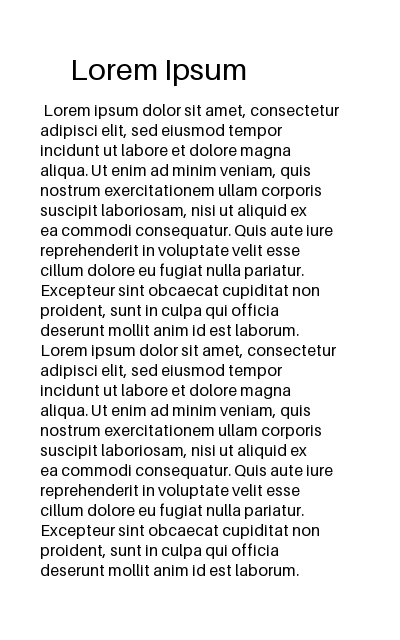

In [11]:
from PIL import Image, ImageDraw, ImageFont
import textwrap

width, height = 400, 640
image = Image.new('L', (width, height), 'white')  # 'L'はグレースケールを意味します
draw = ImageDraw.Draw(image)

# タイトルを描画
title = "Lorem Ipsum"
font = ImageFont.load_default(size=30)
title_x, title_y = 70, 50
draw.text((title_x, title_y), title, fill="black", font=font)

# 本文を描画
dummy_text = """
Lorem ipsum dolor sit amet, consectetur adipisci elit, sed eiusmod tempor incidunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrum exercitationem ullam corporis suscipit laboriosam, nisi ut aliquid ex ea commodi consequatur. Quis aute iure reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint obcaecat cupiditat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum.
"""
dummy_text = dummy_text + dummy_text
# テキストを指定された幅で折り返す
body = textwrap.fill(dummy_text, width=40)
body
font = ImageFont.load_default(size=16)
body_x, body_y = 40, 100
draw.text((body_x, body_y), body, fill="black", font=font)

image

傾かせる

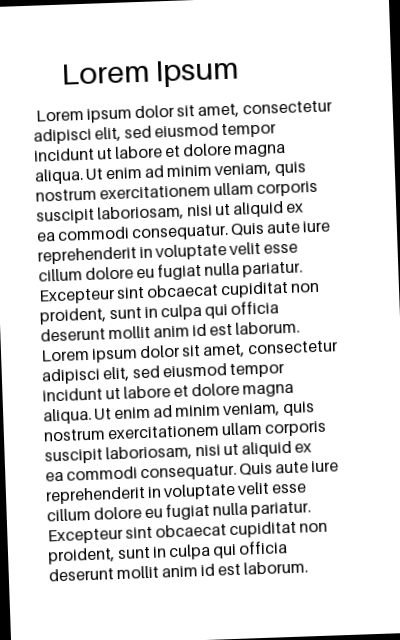

In [12]:
import cv2
import numpy as np

image = np.array(image)

# 回転の中心を画像の中心に設定
(h, w) = image.shape[:2]
center = (w // 2, h // 2)

# 回転のための行列を生成。この例では画像を中心に90度回転
angle = 2  # 回転角度
scale = 1.0  # スケールは変更しない
rotation_matrix = cv2.getRotationMatrix2D(center, angle, scale)

# アフィン変換を適用して画像を回転
image = cv2.warpAffine(image, rotation_matrix, (w, h))

Image.fromarray(image)

## 処理

### Canny法によるエッジ検出

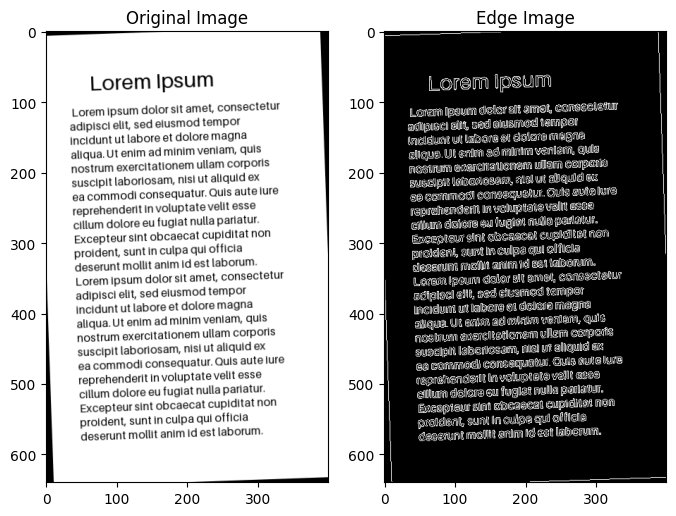

In [13]:
import cv2
import matplotlib.pyplot as plt

# グレースケールに変換
if len(image.shape) == 3:
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Cannyエッジ検出を適用
edges = cv2.Canny(image, threshold1=100, threshold2=200)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# 結果を表示
plt.figure(figsize=(8, 6))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(edges, cmap='gray')
plt.title('Edge Image')
plt.show()

### ハフ変換

HoughLinesとHoughLinesPの違い：

- HoughLinesはすべての点の線を取る
- HoughLinesPは確率的で、ランダムサンプリングした点だけ計算するので効率がいい

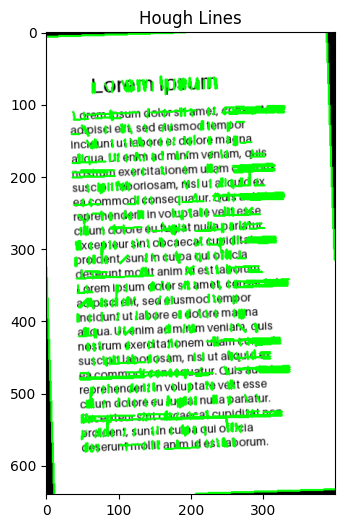

In [14]:
# ハフ変換で直線を検出
lines = cv2.HoughLinesP(edges, rho=1, theta=np.pi/360, threshold=80, minLineLength=10, maxLineGap=5)

# 検出した直線を元の画像に描画
image_for_plot = image.copy()
for line in lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(image_for_plot, (x1, y1), (x2, y2), (0, 255, 0), 2)

# 結果を表示
plt.figure(figsize=(8, 6))
plt.imshow(image_for_plot)
plt.title('Hough Lines')
plt.show()

## 角度の算出

In [31]:
def calc_angle(x1, y1, x2, y2):
    """線の傾きの角度を計算する"""
    # 三角形の横xと縦yを取得
    point1 = np.array([x1, y1])
    point2 = np.array([x2, y2])
    x = point2 - point1
    y = np.array([1, 0])
    # cos θ
    cos_theta = x @ y / np.linalg.norm(x) * np.linalg.norm(y)
    # cos^{-1}でθ（ラジアン）を取得
    radian = np.arccos(cos_theta)
    # radian to degree
    degree = radian * (180 / np.pi)
    return degree

# スケールはコサイン類似度で正規化される
calc_angle(x1=0, y1=0, x2=100, y2=100)

45.00000000000001

In [32]:
# 複数の線の角度を集計
angles = []
for line in lines:
    x1, y1, x2, y2 = line[0]
    angle = calc_angle(x1, y1, x2, y2)
    angles.append(angle)
angles = np.array(angles)

# 縦線は文字の角度を拾っている物が多いので水平に近い線だけをとる
angles = angles[angles < 45]
# 平均をとる
angle = np.mean(angles)
angle

1.2759928327449461

## 回転


### `getRotationMatrix2D`

[OpenCV: Geometric Image Transformations](https://docs.opencv.org/4.x/da/d54/group__imgproc__transform.html#gafbbc470ce83812914a70abfb604f4326)

affine matrix 

$$
\begin{bmatrix}
\alpha & \beta & (1- \alpha ) \cdot \texttt{center.x} - \beta \cdot \texttt{center.y} \\
- \beta & \alpha & \beta \cdot \texttt{center.x} + (1- \alpha ) \cdot \texttt{center.y}
\end{bmatrix}
$$

$$
\begin{array}{l}
\alpha = \texttt{scale} \cdot \cos \texttt{angle},\\
\beta = \texttt{scale} \cdot \sin \texttt{angle}
\end{array}
$$

を取得する

In [19]:
# 回転の中心を画像の中心に設定
(h, w) = image.shape[:2]
center = (w // 2, h // 2)

scale = 1.0  # スケールは変更しない
rotation_matrix = cv2.getRotationMatrix2D(center, -angle, scale)

# アフィン変換を適用して画像を回転
image = cv2.warpAffine(image, rotation_matrix, (w, h))

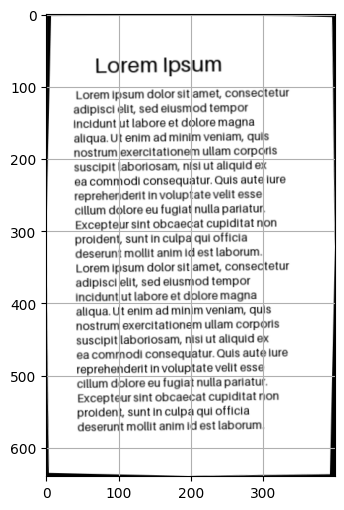

In [22]:
# 結果を表示
plt.figure(figsize=(8, 6))
plt.imshow(image)
plt.grid(True)
plt.show()